In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
!sudo apt install tesseract-ocr
!pip install pytesseract


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  tesseract-ocr-eng tesseract-ocr-osd
The following NEW packages will be installed:
  tesseract-ocr tesseract-ocr-eng tesseract-ocr-osd
0 upgraded, 3 newly installed, 0 to remove and 49 not upgraded.
Need to get 4,816 kB of archives.
After this operation, 15.6 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-eng all 1:4.00~git30-7274cfa-1.1 [1,591 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr-osd all 1:4.00~git30-7274cfa-1.1 [2,990 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy/universe amd64 tesseract-ocr amd64 4.1.1-2.1build1 [236 kB]
Fetched 4,816 kB in 2s (2,660 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debc

In [26]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import (
    Input, Conv2D, Conv2DTranspose, Activation, BatchNormalization, Concatenate
)
from tensorflow.keras.models import Model
import pytesseract
import re
import os
import h5py


In [28]:
# Carregar dados para treinamento do modelo de segmentação
with h5py.File('/content/drive/MyDrive/INTEGRAÇÂO/combined_data.h5', 'r') as h5f:
    x = h5f['X'][:]
    y = h5f['Y'][:]

# Normalizar os dados
x = x / 255.0
y = y / 255.0



In [29]:
def preprocess_image(image_path):
    """
    Carrega e pré-processa a imagem para entrada no modelo de segmentação.
    """
    # Carregar a imagem
    image = cv2.imread(image_path)
    # Redimensionar para o tamanho esperado pelo modelo
    image_resized = cv2.resize(image, (128, 128))
    # Normalizar os valores dos pixels
    image_normalized = image_resized / 255.0
    # Expandir as dimensões para corresponder ao esperado pelo modelo (1, 128, 128, 3)
    image_input = np.expand_dims(image_normalized, axis=0)
    return image_input, image_resized  # Retorna também a imagem redimensionada para uso posterior

def segment_eyes(image_input):
    """
    Usa o modelo de segmentação para prever a máscara dos olhos.
    """
    # Fazer predição
    predicted_mask = model.predict(image_input)
    # Binarizar a máscara
    predicted_mask = (predicted_mask > 0.5).astype(np.uint8)
    # Remover a dimensão extra
    predicted_mask = predicted_mask[0, :, :, 0]
    return predicted_mask

def apply_mask(image_resized, predicted_mask):
    """
    Aplica a máscara predita à imagem original.
    """
    # Garantir que a máscara tenha 3 canais
    mask_3ch = np.stack((predicted_mask,)*3, axis=-1)
    # Aplicar a máscara
    masked_image = cv2.bitwise_and(image_resized, image_resized, mask=predicted_mask)
    return masked_image


In [30]:
def calculate_temperature(masked_image, bar_region, temp_min, temp_max):
    """
    Calcula a temperatura média na região dos olhos usando a calibração da barra de cores.
    """
    # Converter a imagem mascarada para escala de cinza
    gray_masked_image = cv2.cvtColor(masked_image, cv2.COLOR_BGR2GRAY)
    # Extrair os pixels não zero (região dos olhos)
    pixels_not_zero = gray_masked_image[gray_masked_image > 0]
    if len(pixels_not_zero) == 0:
        print("Nenhum pixel encontrado na região dos olhos.")
        return None
    # Calcular a média dos 10% pixels mais brilhantes
    pixels_ordered = np.sort(pixels_not_zero)
    pixels_ordered_reverse = pixels_ordered[::-1]
    pixels_10_percent = pixels_ordered_reverse[:int(len(pixels_ordered_reverse)*0.1)]
    media_pixels = np.mean(pixels_10_percent)
    # Obter valores mínimo e máximo da barra de cores
    min_val = np.min(bar_region)
    max_val = np.max(bar_region)
    # Calcular a temperatura
    temperatura_calculada = ((media_pixels - min_val) / (max_val - min_val)) * (temp_max - temp_min) + temp_min
    return temperatura_calculada


In [31]:
def process_image(image_path, temp_image_path, bar_image_path):
    """
    Pipeline completo para processar uma imagem térmica e calcular a temperatura na região dos olhos.
    """
    # Pré-processar a imagem
    image_input, image_resized = preprocess_image(image_path)
    # Obter a máscara predita
    predicted_mask = segment_eyes(image_input)
    # Aplicar a máscara à imagem original
    masked_image = apply_mask(image_resized, predicted_mask)
    # Extrair temperaturas mínima e máxima usando OCR
    gray_temp_image = cv2.imread(temp_image_path, cv2.IMREAD_GRAYSCALE)
    _, thresh_temp = cv2.threshold(gray_temp_image, 150, 255, cv2.THRESH_BINARY_INV)
    text = pytesseract.image_to_string(thresh_temp, config='--psm 6')
    pattern = r"\d{2}\.\d{2}"
    temperaturas = re.findall(pattern, text)
    if len(temperaturas) < 2:
        print("Não foi possível extrair as temperaturas mínima e máxima.")
        return None
    temp_min = float(temperaturas[1])
    temp_max = float(temperaturas[0])
    # Processar a barra de cores para calibração
    bar_image = cv2.imread(bar_image_path)
    gray_bar_image = cv2.cvtColor(bar_image, cv2.COLOR_BGR2GRAY)
    bar_region = gray_bar_image[:, -50:]
    # Calcular a temperatura
    temperatura_calculada = calculate_temperature(masked_image, bar_region, temp_min, temp_max)
    if temperatura_calculada is None:
        return None
    # Escrever a temperatura na imagem
    posicao_texto = (5, 20)
    fonte = cv2.FONT_HERSHEY_SIMPLEX
    cor = (255, 255, 255)
    tamanho_fonte = 0.6
    espessura = 2
    image_with_temp = image_resized.copy()
    cv2.putText(image_with_temp, f"Temperatura: {temperatura_calculada:.2f}°C", posicao_texto, fonte, tamanho_fonte, cor, espessura)
    return image_with_temp, masked_image, predicted_mask, temperatura_calculada


In [32]:
def preprocess_image(image):
    """
    Pré-processa a imagem para entrada no modelo de segmentação.
    """
    # Redimensionar para o tamanho esperado pelo modelo
    image_resized = cv2.resize(image, (128, 128))
    # Normalizar os valores dos pixels
    image_normalized = image_resized / 255.0
    # Expandir as dimensões para corresponder ao esperado pelo modelo (1, 128, 128, 3)
    image_input = np.expand_dims(image_normalized, axis=0)
    return image_input, image_resized  # Retorna também a imagem redimensionada para uso posterior

def segment_eyes(image_input):
    """
    Usa o modelo de segmentação para prever a máscara dos olhos.
    """
    # Fazer predição
    predicted_mask = model.predict(image_input)
    # Binarizar a máscara
    predicted_mask = (predicted_mask > 0.5).astype(np.uint8)
    # Remover a dimensão extra
    predicted_mask = predicted_mask[0, :, :, 0]
    return predicted_mask

def apply_mask(image_resized, predicted_mask):
    """
    Aplica a máscara predita à imagem original.
    """
    # Garantir que a máscara tenha 3 canais
    mask_3ch = np.stack((predicted_mask,)*3, axis=-1)
    # Aplicar a máscara
    masked_image = cv2.bitwise_and(image_resized, image_resized, mask=predicted_mask)
    return masked_image


In [33]:
def extract_temperatures(image):
    """
    Extrai as temperaturas mínima e máxima da imagem usando OCR.
    """
    # Converter a imagem para escala de cinza
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Aplicar limiarização para melhorar o OCR
    _, thresh = cv2.threshold(gray_image, 150, 255, cv2.THRESH_BINARY_INV)
    # Extrair texto usando OCR
    text = pytesseract.image_to_string(thresh, config='--psm 6')
    # Usar regex para encontrar as temperaturas no formato XX.XX
    pattern = r"\d{2}\.\d{2}"
    temperaturas = re.findall(pattern, text)
    if len(temperaturas) >= 2:
        temp_max = float(temperaturas[0])
        temp_min = float(temperaturas[1])
        return temp_min, temp_max
    else:
        print("Não foi possível extrair as temperaturas mínima e máxima.")
        return None, None

def get_color_bar_values(image):
    """
    Isola a barra de cores e obtém os valores mínimo e máximo de pixel.
    """
    # Converter para escala de cinza
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Definir a região onde está a barra de cores (ajuste conforme necessário)
    bar_region = gray_image[:, -50:]  # Ajuste este valor conforme necessário
    # Encontrar os valores de pixel mínimo e máximo na região da barra
    min_val = np.min(bar_region)
    max_val = np.max(bar_region)
    return min_val, max_val, bar_region


In [34]:
def process_image_single(image_path):
    """
    Pipeline completo para processar uma imagem térmica e calcular a temperatura na região dos olhos.
    """
    # Carregar a imagem
    image = cv2.imread(image_path)
    if image is None:
        print(f"Não foi possível carregar a imagem em {image_path}.")
        return None
    # Pré-processar a imagem
    image_input, image_resized = preprocess_image(image)
    # Obter a máscara predita
    predicted_mask = segment_eyes(image_input)
    # Aplicar a máscara à imagem original
    masked_image = apply_mask(image_resized, predicted_mask)
    # Extrair temperaturas mínima e máxima usando OCR
    temp_min, temp_max = extract_temperatures(image)
    if temp_min is None or temp_max is None:
        print("Não foi possível obter as temperaturas mínima e máxima.")
        return None
    # Processar a barra de cores para calibração
    min_val, max_val, bar_region = get_color_bar_values(image)
    # Calcular a temperatura
    temperatura_calculada = calculate_temperature(masked_image, bar_region, temp_min, temp_max)
    if temperatura_calculada is None:
        return None
    # Escrever a temperatura na imagem
    posicao_texto = (5, 20)
    fonte = cv2.FONT_HERSHEY_SIMPLEX
    cor = (255, 255, 255)
    tamanho_fonte = 0.6
    espessura = 2
    image_with_temp = image_resized.copy()
    cv2.putText(image_with_temp, f"Temperatura: {temperatura_calculada:.2f}°C", posicao_texto, fonte, tamanho_fonte, cor, espessura)
    return image_with_temp, masked_image, predicted_mask, temperatura_calculada


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 497ms/step


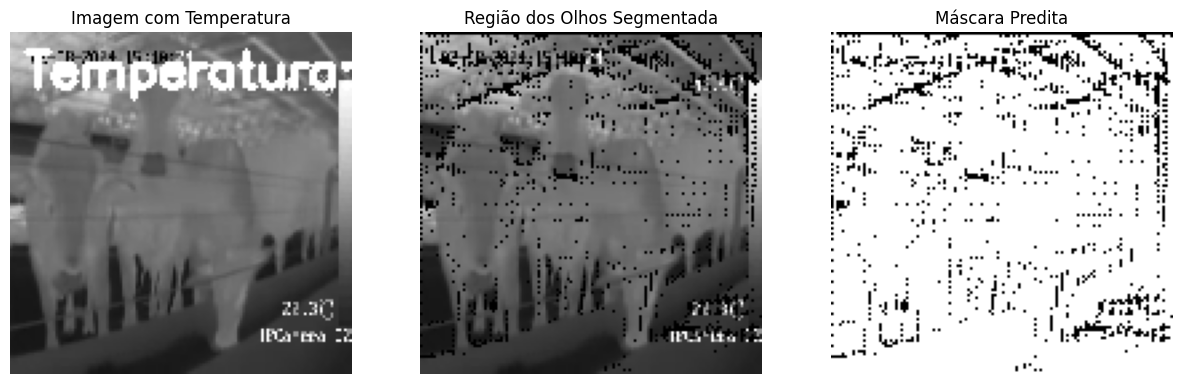

Temperatura Calculada: 35.66°C


In [35]:
# Definir o caminho da imagem
image_path = '/content/drive/MyDrive/INTEGRAÇÂO/frame_7307.png'  # Sua imagem térmica

# Verificar se a imagem existe
if not os.path.exists(image_path):
    print(f"Imagem térmica não encontrada em {image_path}.")
else:
    # Executar o pipeline
    result = process_image_single(image_path)

    if result is not None:
        image_with_temp, masked_image, predicted_mask, temperatura_calculada = result
        # Mostrar os resultados
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(cv2.cvtColor(image_with_temp, cv2.COLOR_BGR2RGB))
        plt.title('Imagem com Temperatura')
        plt.axis('off')
        plt.subplot(1, 3, 2)
        plt.imshow(cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB))
        plt.title('Região dos Olhos Segmentada')
        plt.axis('off')
        plt.subplot(1, 3, 3)
        plt.imshow(predicted_mask, cmap='gray')
        plt.title('Máscara Predita')
        plt.axis('off')
        plt.show()
        print(f"Temperatura Calculada: {temperatura_calculada:.2f}°C")
    else:
        print("O processamento falhou.")
